In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyteomics import mzxml
%matplotlib inline
import rpy2.robjects as ro
from rpy2.robjects.vectors import IntVector, FloatVector
ro.r['options'](warn=-1)

C:\Users\jcho\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


warn
0


In [2]:
def loess():
    rstring = """
    loess.as = function(x, y, degree = 1, criterion="aicc", family="gaussian", user.span=NULL, plot=FALSE, ...) {

        criterion <- match.arg(criterion)
        family <- match.arg(family)
        x <- as.matrix(x)

        if ((ncol(x) != 1) & (ncol(x) != 2)) stop("The predictor 'x' should be one or two dimensional!!")
        if (!is.numeric(x)) stop("argument 'x' must be numeric!")
        if (!is.numeric(y)) stop("argument 'y' must be numeric!")
        if (any(is.na(x))) stop("'x' contains missing values!")
        if (any(is.na(y))) stop("'y' contains missing values!")
        if (!is.null(user.span) && (length(user.span) != 1 || !is.numeric(user.span))) 
            stop("argument 'user.span' must be a numerical number!")
        if(nrow(x) != length(y)) stop("'x' and 'y' have different lengths!")
        if(length(y) < 3) stop("not enough observations!")

        data.bind <- data.frame(x=x, y=y)
        if (ncol(x) == 1) {
            names(data.bind) <- c("x", "y")
        } else { names(data.bind) <- c("x1", "x2", "y") }

        opt.span <- function(model, criterion=c("aicc", "gcv"), span.range=c(.05, .95)){
            as.crit <- function (x) {
                span <- x$pars$span
                traceL <- x$trace.hat
                sigma2 <- sum(x$residuals^2 ) / (x$n-1)
                aicc <- log(sigma2) + 1 + 2* (2*(traceL+1)) / (x$n-traceL-2)
                gcv <- x$n*sigma2 / (x$n-traceL)^2
                result <- list(span=span, aicc=aicc, gcv=gcv)
                return(result)
            }
            criterion <- match.arg(criterion)
            fn <- function(span) {
                mod <- update(model, span=span)
                as.crit(mod)[[criterion]]
            }
            result <- optimize(fn, span.range)
            return(list(span=result$minimum, criterion=result$objective))
        }

        control = loess.control(surface = "direct")
        if (ncol(x)==1) {
            if (is.null(user.span)) {
                fit0 <- loess(y ~ x, degree=degree, family=family, data=data.bind, control=control, ...)
                span1 <- opt.span(fit0, criterion=criterion)$span
            } else {
                span1 <- user.span
            }
            fit <- loess(y ~ x, degree=degree, span=span1, family=family, data=data.bind, control=control, ...)
        } else {
            if (is.null(user.span)) {
                fit0 <- loess(y ~ x1 + x2, degree=degree,family=family, data.bind, control=control, ...)
                span1 <- opt.span(fit0, criterion=criterion)$span
            } else {
                span1 <- user.span
            }
            fit <- loess(y ~ x1 + x2, degree=degree, span=span1, family=family, data=data.bind, control=control...)
        }
        return(fit)
    }
    """
    return ro.r(rstring)


In [3]:
inputFile = "isotope_distribution.xlsx"
paramFile = "jumpm_targeted.params"
mzxmlFile = r"C:\Users\jcho\OneDrive - St. Jude Children's Research Hospital\UDrive\Research\Projects\7Metabolomics\Datasets\13Ctracer_rawdata\7_tracer.mzXML"

# Input dataframe (from Surendhar's program)
inputDf = pd.read_excel(inputFile)
reader = mzxml.MzXML(mzxmlFile)

# # Pyteomics reader to pandas DataFrame
# spec = pd.DataFrame(reader)
# spec.drop(columns=["peaksCount", "polarity", "scanType", "lowMz", "highMz",
#                  "basePeakMz", "basePeakIntensity", "totIonCurrent", "id",
#                  "collisionEnergy", "precursorMz"], inplace=True)
# spec = spec[spec["msLevel"] == 1].reset_index(drop=True)
# spec = spec.apply(pd.Series.explode)    # This operation extracts "m/z array" and "intensity array" into columns

In [4]:
# Extract m/z values and unique IDs of given metabolites (from an excel file)
mzs = [float(mz.split(";")[0]) for mz in inputDf.groupby("idhmdb").min()["isotope_M/Z"]]
uids = inputDf.groupby("idhmdb", as_index=False).min()["idhmdb"]
gMinMz, gMaxMz = min(mzs) - 10, max(mzs) + 10    # minimum and maximum m/z values to be considered

# Sort m/z values and unique IDs accordingly
idx = np.argsort(mzs)
mzs = sorted(mzs)
uids = uids[idx]

# Extract MS1 spectra (m/z array and intensity array are reduced)
ms1 = []
for spec in reader:
    if spec["msLevel"] == 1:
        idx = (spec["m/z array"] >= gMinMz) & (spec["m/z array"] <= gMaxMz)
        spec["m/z array"] = spec["m/z array"][idx]
        spec["intensity array"] = spec["intensity array"][idx]
        ms1.append(spec)
df = pd.DataFrame(ms1)
df.drop(columns=["peaksCount", "polarity", "scanType", "lowMz", "highMz", "basePeakMz", 
                 "basePeakIntensity", "totIonCurrent", "id", "msLevel", "filterLine"], inplace=True)
df = df.apply(pd.Series.explode)    # This operation extracts "m/z array" and "intensity array" into columns

In [ ]:
def correctMz(input, refMz):
    df = input.copy()
    # Estimate the m/z-shifts around the "refMz" by investigating the peaks around "refMz" +/- 50 ppm
    lL = refMz - refMz * 50 / 1e6
    uL = refMz + refMz * 50 / 1e6
    rows = (df["m/z array"] >= lL) & (df["m/z array"] <= uL)
    # When there are multiple peaks within the tolerance in a MS1 scan, the strongest peak is considered
    subDf = df[rows].sort_values("intensity array", ascending=False).groupby("num", as_index=False).first()
    # LOESS modeling and m/z correction
    x = subDf["retentionTime"]
    y = (subDf["m/z array"] - monoMz) / monoMz * 1e6    # m/z-shifts measured in PPM
    mod = rLoess(FloatVector(x), FloatVector(y), 1, "aicc", "gaussian")
    df["m/z array"] = df["m/z array"] / (1 + np.array(rPredict(mod, FloatVector(df["retentionTime"]))) / 1e6)
    return df

In [ ]:
def getScanIndex(df, mz, tol):
    lL = mz - mz * tol / 1e6
    uL = mz + mz * tol / 1e6
    rows = (df["m/z array"] >= lL) & (df["m/z array"] <= uL)
    res = df.loc[rows].index
    return res    

In [10]:
# mzShifts = {}
rLoess = loess()
rPredict = ro.r("predict")
tol = 10
for uid in [uids[0]]:
    # m/z values of isotopologues
    mzs = [float(mz.split(";")[0]) for mz in inputDf[inputDf["idhmdb"] == uid]["isotope_M/Z"]]
    # m/z correction (only based on the monoisitopic m/z)
    dfCorrected = correctMz(df, mzs[0])
    # Feature finding
    scanIdx = []
    for mz in mzs:
        if len(scanIdx) > 0:
            scanIdx = np.intersect1d(scanIdx, getScanIndex(df, mz, tol))
        else:
            scanIdx = getScanIndex(df, mz, tol)
    # Feature detection with considering the gap in MS1 scan
    if len(scanIdx) > 0:
        idxArray = []
        j = 0
        for i in range(1, len(scanIdx)):
            if scanIdx[i] - scanIdx[i - 1] > gap:
                if i - j > 1:  # Avoid "singleton" features
                    idxArray.append(scanIdx[j: i])
                j = i
            else:
                if i == len(scanIdx) - 1:  # Last element
                    idxArray.append(scanIdx[j: len(scanIdx)])
        for idx in idxArray:
            # Define feature(s)
            f = defineFeature(uid, monoMzs, tol, idx, spec)
            fArray.append(f)

    

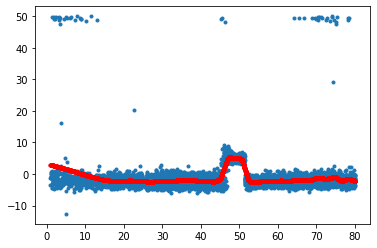

In [18]:
plt.plot(mod.rx2("x"), mod.rx2("y"), '.')
plt.plot(mod.rx2("x"), mod.rx2("fitted"), '.', color="red")


In [14]:
reader["1"]["m/z array"]

array([ 85.00377 ,  85.99872 ,  85.999565,  86.023796,  86.87761 ,
        87.00781 ,  87.008835,  87.01919 ,  87.04426 ,  89.02353 ,
        89.02444 ,  90.00876 ,  90.027115,  91.02905 ,  92.02466 ,
        92.025536,  92.92729 ,  92.97385 ,  92.97441 ,  93.00841 ,
        93.378746,  94.00343 ,  94.00418 ,  94.01504 ,  94.35894 ,
        94.924034,  94.97083 ,  94.97975 ,  95.023964,  95.979515,
        96.00801 ,  97.03957 ,  97.948814,  98.023796,  98.95475 ,
        99.00808 , 100.003204, 100.95998 , 101.02349 , 101.05996 ,
       101.65707 , 102.06322 , 103.01396 , 103.03896 , 103.03953 ,
       104.02458 , 105.01845 , 106.04002 , 107.02418 , 107.043495,
       108.01927 , 108.03064 , 109.039795, 109.99881 , 110.02405 ,
       111.00778 , 111.01917 , 112.003   , 112.01444 , 112.03937 ,
       112.83805 , 112.90365 , 112.96232 , 112.96355 , 112.96556 ,
       112.98478 , 112.99828 , 113.00675 , 113.02345 , 113.03185 ,
       113.0346  , 113.05963 , 113.988075, 114.018585, 114.055